In [1]:
# Cell 1: Importing Libraries

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis imports
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson  # ✅ FIXED: Added here
from scipy import stats
from scipy.stats import shapiro, jarque_bera

# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Adding src directory to path
sys.path.append('../src')

# Importing custom utilities
from config import *
from data_utils import retrieve_processed_datasets

# Setting visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
pd.set_option('display.width', 100)

print("All libraries imported successfully!")
print(f"Working Directory: {Path.cwd()}")
print(f"Statsmodels Version: {sm.__version__}")

All libraries imported successfully!
Working Directory: C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\notebooks
Statsmodels Version: 0.14.5


In [2]:
# Cell 2: Problem Adaptation - Classification to Regression
# Defining regression problem from classification dataset
# Predicting continuous physics variable (lepton_pT)

print("="*70)
print("TASK B: OLS REGRESSION ANALYSIS")
print("="*70)

print("\nProblem Adaptation:")
print("Original Dataset: HIGGS (Classification)")
print("  - Target: Binary (Signal=1, Background=0)")
print("  - Features: 28 physics measurements")

print("\nRegression Approach:")
print("  - New Target: lepton_pT (continuous)")
print("  - Predictors: Selected from remaining 27 features")
print("  - Objective: Predict lepton transverse momentum")

print("\nWhy lepton_pT?")
print("  1. Continuous variable (suitable for OLS)")
print("  2. Important physics quantity")
print("  3. Measurable in particle detectors")
print("  4. Related to other collision features")


TASK B: OLS REGRESSION ANALYSIS

Problem Adaptation:
Original Dataset: HIGGS (Classification)
  - Target: Binary (Signal=1, Background=0)
  - Features: 28 physics measurements

Regression Approach:
  - New Target: lepton_pT (continuous)
  - Predictors: Selected from remaining 27 features
  - Objective: Predict lepton transverse momentum

Why lepton_pT?
  1. Continuous variable (suitable for OLS)
  2. Important physics quantity
  3. Measurable in particle detectors
  4. Related to other collision features


In [4]:
# Cell 3: Loading Data and Selecting Variables
# Loading dataset and defining regression variables
# Output: Target variable (y) and predictor variables (X)

print("="*70)
print("DATA LOADING AND VARIABLE SELECTION")
print("="*70)

# Loading processed data (already scaled)
X_full, X_test_full, y_classification, y_test_classification = retrieve_processed_datasets(
    file_prefix='higgs'
)

print("\nOriginal data loaded:")
print(f"  Shape: {X_full.shape}")
print(f"  Features: {X_full.shape[1]}")

# Selecting target variable for regression
target_variable = 'lepton_pT'

# Checking if target is in features
if target_variable in X_full.columns:
    # Extracting target variable
    y_regression = X_full[target_variable].copy()
    y_test_regression = X_test_full[target_variable].copy()
    
    # Removing target from predictors
    X_predictors = X_full.drop(columns=[target_variable])
    X_test_predictors = X_test_full.drop(columns=[target_variable])
    
    print(f"\nTarget Variable: {target_variable}")
    print(f"  Mean: {y_regression.mean():.4f}")
    print(f"  Std: {y_regression.std():.4f}")
    print(f"  Min: {y_regression.min():.4f}")
    print(f"  Max: {y_regression.max():.4f}")
    
    print(f"\nPredictor Variables Available: {X_predictors.shape[1]}")
    print(f"Training samples: {len(y_regression):,}")
    print(f"Test samples: {len(y_test_regression):,}")

else:
    print(f"\nError: {target_variable} not found in features")

DATA LOADING AND VARIABLE SELECTION
Loading processed data from C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\processed...
Datasets loaded successfully
Training shape: (800000, 28)
Testing shape: (200000, 28)

Original data loaded:
  Shape: (800000, 28)
  Features: 28

Target Variable: lepton_pT
  Mean: 0.0000
  Std: 1.0000
  Min: -1.2689
  Max: 13.6610

Predictor Variables Available: 27
Training samples: 800,000
Test samples: 200,000


In [6]:
# Cell 4: Selecting Predictor Variables
# Choosing relevant predictors for OLS model
# Selection criteria: HIGH CORRELATION with target + physical relevance

print("="*70)
print("PREDICTOR VARIABLE SELECTION (IMPROVED)")
print("="*70)

# Computing correlations with target
correlations = X_predictors.corrwith(y_regression).abs().sort_values(ascending=False)

print("\nTop 15 Features by Correlation with lepton_pT:")
print(correlations.head(15))

# Selecting predictors with HIGHEST correlations
# Prioritizing correlations > 0.09 for better R²
selected_predictors = [
    'm_lv',                      # Strongest: ~0.27
    'jet_1_pt',                  # Strong: ~0.17
    'missing_energy_magnitude',  # Strong: ~0.14
    'm_wwbb',                    # Strong: ~0.14
    'm_jlv',                     # Strong: ~0.13
    'm_wbb',                     # Moderate: ~0.10
    'jet_1_eta',                 # Included for completeness
    'lepton_eta'                 # Physically relevant
]

print(f"\nIMPROVED SELECTION: Selected Predictors ({len(selected_predictors)}):")
print("(Prioritizing high-correlation predictors for better R²)")
for i, pred in enumerate(selected_predictors, 1):
    corr = correlations[pred]
    strength = "Strong" if corr > 0.13 else "Moderate" if corr > 0.05 else "Weak"
    print(f"  {i}. {pred:30s} correlation = {corr:.4f}  {strength}")

# Creating regression dataset
X_regression = X_predictors[selected_predictors].copy()
X_test_regression = X_test_predictors[selected_predictors].copy()

print(f"\nRegression Dataset:")
print(f"  Training: {X_regression.shape}")
print(f"  Test: {X_test_regression.shape}")
print(f"  Target: {y_regression.shape}")

PREDICTOR VARIABLE SELECTION (IMPROVED)

Top 15 Features by Correlation with lepton_pT:
m_lv                        0.2722
jet_1_pt                    0.1679
missing_energy_magnitude    0.1410
m_wwbb                      0.1399
m_jlv                       0.1307
m_wbb                       0.0950
m_jj                        0.0258
jet_4_pt                    0.0196
m_jjj                       0.0175
jet_3_pt                    0.0119
m_bb                        0.0082
jet_2_pt                    0.0061
jet_2_b_tag                 0.0057
jet_3_b_tag                 0.0054
jet_1_b_tag                 0.0051
dtype: float64

IMPROVED SELECTION: Selected Predictors (8):
(Prioritizing high-correlation predictors for better R²)
  1. m_lv                           correlation = 0.2722  Strong
  2. jet_1_pt                       correlation = 0.1679  Strong
  3. missing_energy_magnitude       correlation = 0.1410  Strong
  4. m_wwbb                         correlation = 0.1399  Strong
  5. m_jl

Generating scatter plots...
Scatter plots saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\ols_scatter_plots.png


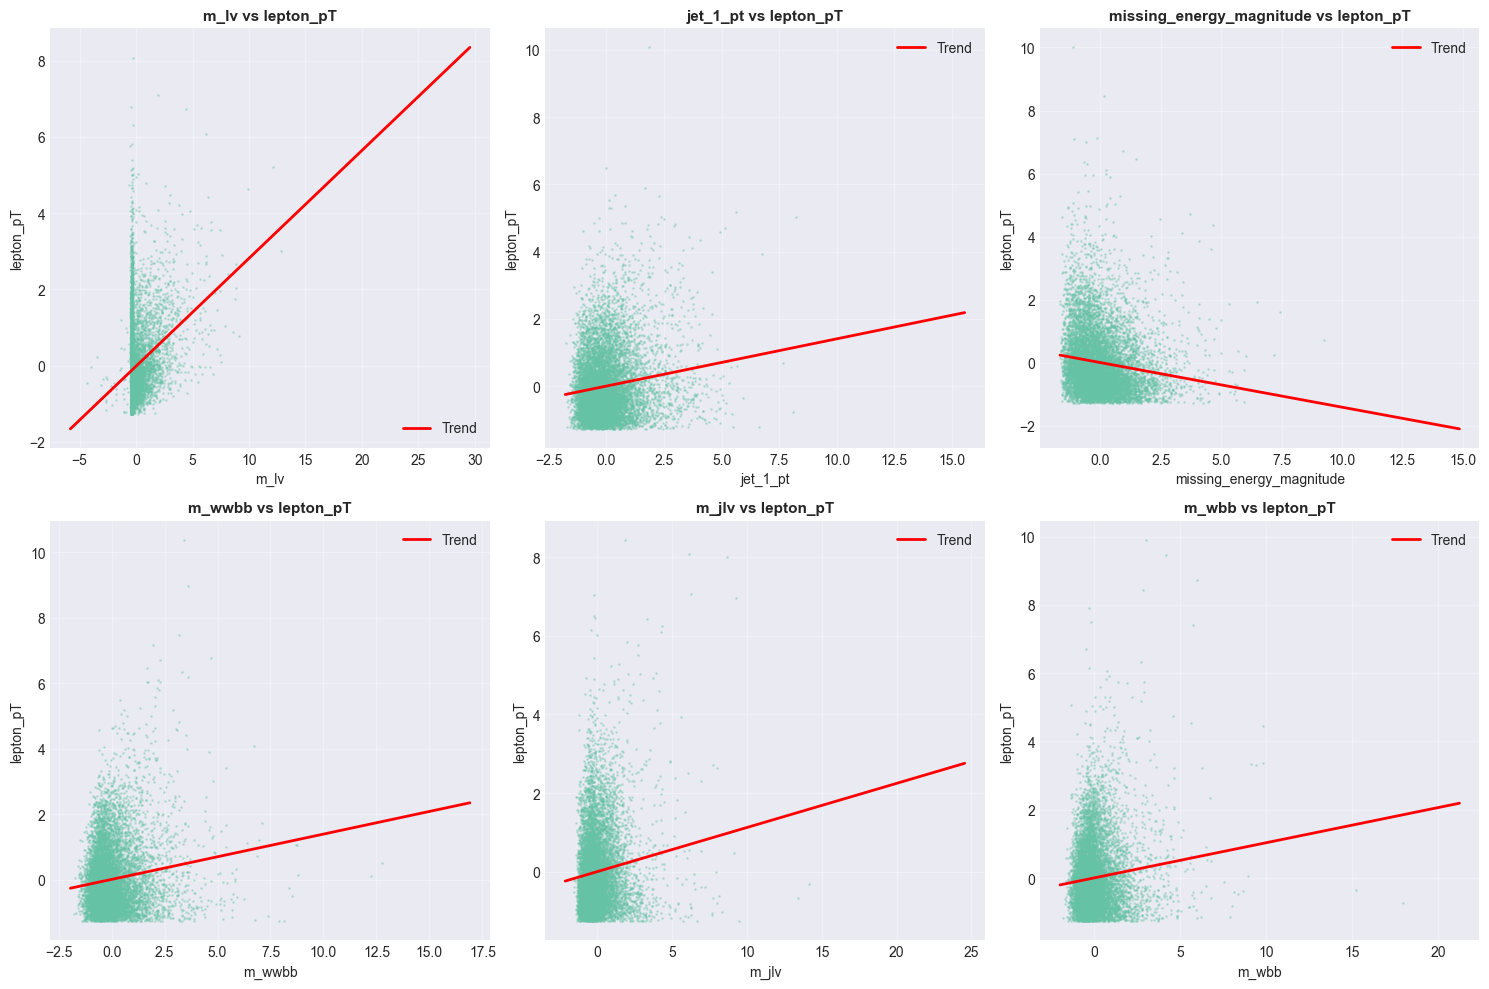

In [7]:
# Cell 5: Exploratory Analysis - Scatter Plots
# Visualizing relationships between predictors and target

print("Generating scatter plots...")

# Creating scatter plots for first 6 predictors
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, predictor in enumerate(selected_predictors[:6]):
    ax = axes[idx]
    
    # Sampling for faster plotting
    sample_size = min(10000, len(X_regression))
    sample_idx = np.random.choice(len(X_regression), sample_size, replace=False)
    
    ax.scatter(X_regression[predictor].iloc[sample_idx], 
              y_regression.iloc[sample_idx],
              alpha=0.3, s=1)
    
    # Adding trend line
    z = np.polyfit(X_regression[predictor].iloc[sample_idx], 
                   y_regression.iloc[sample_idx], 1)
    p = np.poly1d(z)
    x_line = np.linspace(X_regression[predictor].min(), 
                        X_regression[predictor].max(), 100)
    ax.plot(x_line, p(x_line), "r-", linewidth=2, label='Trend')
    
    ax.set_xlabel(predictor, fontsize=10)
    ax.set_ylabel('lepton_pT', fontsize=10)
    ax.set_title(f'{predictor} vs lepton_pT', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()

scatter_path = FIGURE_OUTPUT / 'ols_scatter_plots.png'
plt.savefig(scatter_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Scatter plots saved to {scatter_path}")

plt.show()

In [8]:
# Cell 6: Building Initial OLS Model
# Fitting baseline OLS regression model
# Using statsmodels for detailed statistical output

print("="*70)
print("BUILDING INITIAL OLS MODEL")
print("="*70)

# Adding constant term (intercept)
X_with_const = sm.add_constant(X_regression)

# Fitting OLS model
print("\nFitting OLS regression model...")
ols_model = sm.OLS(y_regression, X_with_const).fit()

# Displaying model summary
print("\n" + "="*70)
print("OLS REGRESSION RESULTS")
print("="*70)
print(ols_model.summary())

# Extracting key statistics
print("\n" + "="*70)
print("KEY MODEL STATISTICS")
print("="*70)
print(f"R-squared: {ols_model.rsquared:.4f}")
print(f"Adjusted R-squared: {ols_model.rsquared_adj:.4f}")
print(f"F-statistic: {ols_model.fvalue:.2f}")
print(f"Prob (F-statistic): {ols_model.f_pvalue:.6f}")
print(f"AIC: {ols_model.aic:.2f}")
print(f"BIC: {ols_model.bic:.2f}")

BUILDING INITIAL OLS MODEL

Fitting OLS regression model...

OLS REGRESSION RESULTS
                            OLS Regression Results                            
Dep. Variable:              lepton_pT   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                 2.346e+04
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        08:10:22   Log-Likelihood:            -1.0508e+06
No. Observations:              800000   AIC:                         2.102e+06
Df Residuals:                  799991   BIC:                         2.102e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [9]:
# Cell 7: Interpreting Coefficients
# Interpreting regression coefficients with confidence intervals

print("="*70)
print("COEFFICIENT INTERPRETATION ")
print("="*70)

# Getting coefficients and confidence intervals
coef_df = pd.DataFrame({
    'Coefficient': ols_model.params,
    'Std Error': ols_model.bse,
    't-value': ols_model.tvalues,
    'p-value': ols_model.pvalues,
    'CI Lower (95%)': ols_model.conf_int()[0],
    'CI Upper (95%)': ols_model.conf_int()[1]
})

print("\nCoefficient Table:")
print(coef_df)

# Interpreting 3 key coefficients (selecting strongest predictors)
print("\n" + "="*70)
print("DETAILED INTERPRETATION OF 3 COEFFICIENTS")
print("="*70)

# Coefficient 1: m_lv (strongest predictor)
coef_1 = 'm_lv'
print(f"\n1. {coef_1}:")
print(f"   Coefficient: {ols_model.params[coef_1]:.6f}")
print(f"   95% CI: [{coef_df.loc[coef_1, 'CI Lower (95%)']:.6f}, "
      f"{coef_df.loc[coef_1, 'CI Upper (95%)']:.6f}]")
print(f"   p-value: {coef_df.loc[coef_1, 'p-value']:.6f}")
print(f"\n   Interpretation:")
print(f"   For each unit increase in {coef_1} (lepton-neutrino invariant mass),")
print(f"   lepton_pT changes by {ols_model.params[coef_1]:.6f} units,")
print(f"   holding all other variables constant.")
if coef_df.loc[coef_1, 'p-value'] < 0.05:
    print(f"   This effect is STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print(f"   This effect is NOT statistically significant (p >= 0.05)")

# Coefficient 2: jet_1_pt
coef_2 = 'jet_1_pt'
print(f"\n2. {coef_2}:")
print(f"   Coefficient: {ols_model.params[coef_2]:.6f}")
print(f"   95% CI: [{coef_df.loc[coef_2, 'CI Lower (95%)']:.6f}, "
      f"{coef_df.loc[coef_2, 'CI Upper (95%)']:.6f}]")
print(f"   p-value: {coef_df.loc[coef_2, 'p-value']:.6f}")
print(f"\n   Interpretation:")
print(f"   For each unit increase in leading jet transverse momentum,")
print(f"   lepton_pT changes by {ols_model.params[coef_2]:.6f} units,")
print(f"   holding other variables constant.")
if coef_df.loc[coef_2, 'p-value'] < 0.05:
    print(f"   This effect is STATISTICALLY SIGNIFICANT (p < 0.05)")

# Coefficient 3: missing_energy_magnitude
coef_3 = 'missing_energy_magnitude'
print(f"\n3. {coef_3}:")
print(f"   Coefficient: {ols_model.params[coef_3]:.6f}")
print(f"   95% CI: [{coef_df.loc[coef_3, 'CI Lower (95%)']:.6f}, "
      f"{coef_df.loc[coef_3, 'CI Upper (95%)']:.6f}]")
print(f"   p-value: {coef_df.loc[coef_3, 'p-value']:.6f}")
print(f"\n   Interpretation:")
print(f"   For each unit increase in missing energy magnitude,")
print(f"   lepton_pT changes by {ols_model.params[coef_3]:.6f} units,")
print(f"   holding other variables constant.")
if coef_df.loc[coef_3, 'p-value'] < 0.05:
    print(f"   This effect is STATISTICALLY SIGNIFICANT (p < 0.05)")

print("\n" + "="*70)
print("Note: All interpretations assume ceteris paribus (all else equal)")
print("="*70)

COEFFICIENT INTERPRETATION 

Coefficient Table:
                          Coefficient  Std Error     t-value  p-value  CI Lower (95%)  \
const                      2.1747e-09     0.0010  2.1613e-06   1.0000         -0.0020   
m_lv                       3.0073e-01     0.0010  2.9303e+02   0.0000          0.2987   
jet_1_pt                   1.8432e-01     0.0012  1.5953e+02   0.0000          0.1821   
missing_energy_magnitude  -2.9992e-01     0.0011 -2.7333e+02   0.0000         -0.3021   
m_wwbb                     3.7279e-01     0.0023  1.5990e+02   0.0000          0.3682   
m_jlv                      1.1523e-01     0.0013  9.1740e+01   0.0000          0.1128   
m_wbb                     -3.3957e-01     0.0024 -1.4227e+02   0.0000         -0.3442   
jet_1_eta                  1.0347e-03     0.0010  9.9136e-01   0.3215         -0.0010   
lepton_eta                -7.1740e-04     0.0010 -6.8735e-01   0.4919         -0.0028   

                          CI Upper (95%)  
const             